*disclaimer: this is not an official Digital Earth African notebook*

# Water detection and dam monitoring with Sentinel 2 imagery <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[WOfS](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) and [s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Background
The United Nations have prescribed 17 *"Sustainable Development Goals"* (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook, like the [Water_extent.ipynb](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Water_extent.ipynb), primarily focuses on the first sub-indicator - spatial extents. It uses the annual  [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) as validation and the [Sentinel 2](https://explorer.digitalearth.africa/s2_l2a) for monitoring.

In [1]:
#load the magic
%matplotlib inline
import matplotlib.pyplot as plt


import os
import sys
from shapely.geometry import Polygon
import geopandas as gpd

from affine import Affine

import datacube
from datacube.utils.cog import write_cog

sys.path.append('../Scripts')
from deafrica_datahandling import mostcommon_crs
from deafrica_datahandling import load_ard, wofs_fuser
from deafrica_spatialtools import xr_vectorize, xr_rasterize
from deafrica_plotting import display_map, rgb, map_shapefile
from deafrica_bandindices import calculate_indices
from deafrica_classificationtools import HiddenPrints
from deafrica_dask import create_local_dask_cluster

#This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
dc = datacube.Datacube(app="water_Theewaterskloof")

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:42449 Dashboard: /user/arkriger/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


## Validation
We query [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) and retrieve a validation dataset.
- Then we filter the dataset to only include the necessary *- We will use this later as a mask to investigate a specific area.*

In [4]:
#enter a location
lat, lon = -34.02, 19.212
buffer = 0.09

# Create a query
wofs_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    
    #we set 2015 as the validation year
    'time': ('2015'),
    #crs = utm34S
    'output_crs':'EPSG:22234'
}

# Load WoFS through the datacube
ds = dc.load(product='ga_ls8c_wofs_2_annual_summary', 
             align=(15, 15),
             resolution=(-30, 30),
             **wofs_query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 567, y: 676)
Coordinates:
  * time         (time) datetime64[ns] 2015-07-02T11:59:59.999500
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    count_clear  (time, y, x) int16 16 16 16 16 16 16 16 ... 18 17 17 17 17 17
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:22234
    grid_mapping:  spatial_ref


### Plot the WOfS summary and Vectorize an `xarray.DataArray`

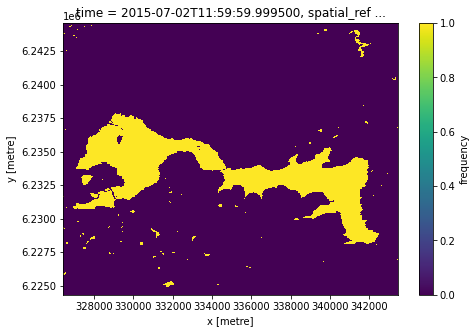

In [5]:
# Select pixels that are classified as water > 40 % of the year
water_bodies = ds.frequency > 0.40

# Plot the data
water_bodies.plot(size=5)
plt.show()

In [6]:
#vectorize
gdf = xr_vectorize(water_bodies,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=water_bodies.values==1)

#print(gdf.head())

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Basic cleaning

> Set a minimum area to exclude smaller water bodies.

In [27]:
#we create a new dataframe with polygon.area > 1 000 000
gdf_clean = gdf[gdf['geometry'].area > 1000000]

#reset index
gdf_clean.reset_index(drop=True, inplace=True)

#add an 'id' column
gdf_clean['id']=range(0, len(gdf_clean))
field = 'id'

/env/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [8]:
#check how they differ
print(len(gdf))
print(len(gdf_clean))

150
3


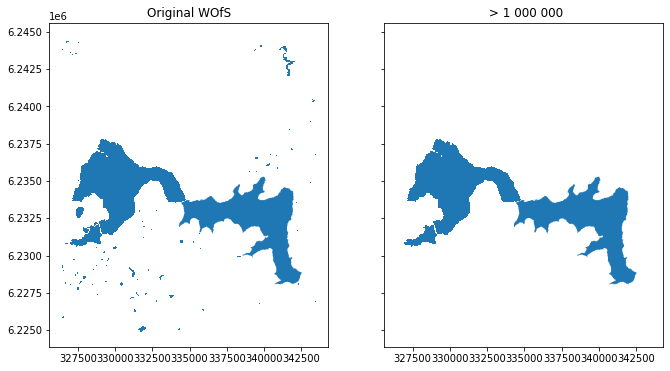

In [9]:
# Plot the two
fig, ax = plt.subplots(1, 2, figsize=(11, 9), sharex=True, sharey=True)

gdf.plot(ax=ax[0])
gdf_clean.plot(ax=ax[1])
#title
ax[0].set_title('Original WOfS')
ax[1].set_title(' > 1 000 000')

plt.show()

In [10]:
#check the .crs
gdf_clean.crs

<Projected CRS: EPSG:22234>
Name: Cape / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Botswana - west of 24°E
- bounds: (19.99, -26.88, 24.0, -17.99)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: Cape
- Ellipsoid: Clarke 1880 (Arc)
- Prime Meridian: Greenwich

In [11]:
#check the polygon over laps the area of interest visually
map_shapefile(gdf_clean, attribute=field)

Label(value='')

Map(center=[-34.03375882863192, 19.20872447874712], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [12]:
#have a look at the data
gdf_clean

,attribute,geometry,id
0,1.0,"POLYGON ((329085.000 6237825.000, 329085.000 6...",0
1,1.0,"POLYGON ((328845.000 6232095.000, 328845.000 6...",1
2,1.0,"POLYGON ((339975.000 6235305.000, 339975.000 6...",2


In [13]:
#not necessary
display_map(x=(lon-buffer, lon+buffer), y=(lat+buffer, lat-buffer))

## Load Sentinel 2 data

In [14]:
# Define the start year and end year
start_year = '2017-01-01'
end_year = '2020-08-01'

#Create a query object
sen_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'resolution': (-10, 10),
    'output_crs':'EPSG:22234',
    'group_by': 'solar_day',
    'time': (start_year, end_year),
    'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [15]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      min_gooddata = 0.75,
                      **sen_query)

../Scripts/deafrica_datahandling.py:240: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 125 out of 236 time steps with at least 75.0% good quality pixels
Applying pixel quality/cloud mask
Returning 125 time steps as a dask array


In [16]:
ds_sen2.crs

'EPSG:22234'

In [17]:
ds_sen2.transform

AttributeError: 'Dataset' object has no attribute 'transform'

In [18]:
ds_sen2.affine

Affine(10.0, 0.0, 326460.0,
       0.0, -10.0, 6244600.0)

## Compute band indices

In [19]:
# Calculate NDWI and add it to the loaded data set
ds_sen2 = calculate_indices(ds_sen2, index="NDWI", collection="s2")
ds_index = ds_sen2.NDWI

In [20]:
print(ds_sen2.NDWI)

<xarray.DataArray 'NDWI' (time: 125, y: 2026, x: 1698)>
dask.array<truediv, shape=(125, 2026, 1698), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T08:45:43 ... 2020-07-19T08:...
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234


## Mask area with the WOfS data *(water extent)*

In [21]:
#set polygons as mask 
with HiddenPrints():
    mask = xr_rasterize(gdf_clean, ds_sen2)
ds_sen2 = ds_sen2.where(mask)

## Calculate the area per pixel and the extent of water

In [22]:
# Constants for calculating waterbody area
pixel_length = sen_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres

area_per_pixel = pixel_length**2 / m_per_km**2

In [23]:
# Filter the data to contain only pixels classified as water
ds_waterarea = ds_sen2.where(ds_sen2.NDWI > 0.1)

# Calculate the total water area (in km^2)
waterarea = (
    ds_waterarea.NDWI.count(dim=["x", "y"])
    .rolling(time=3, center=True, min_periods=1)
    .median(skipna=True)
    * area_per_pixel
)

In [24]:
ds_waterarea.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (time: 125, x: 1698, y: 2026)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01T08:45:43 ... 2020-07-19T08:...
  * y            (y) float64 6.245e+06 6.245e+06 ... 6.224e+06 6.224e+06
  * x            (x) float64 3.265e+05 3.265e+05 ... 3.434e+05 3.434e+05
    spatial_ref  int32 22234
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    NDWI         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:22234
    grid_mapping:  spatial_ref>

### Plot Monthly Time Series from the `Start year` to `End year`

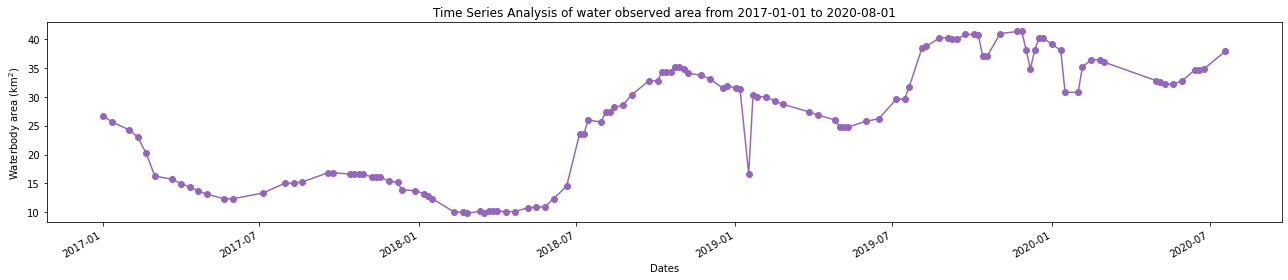

In [29]:
#graph
plt.figure(figsize=(18, 4))
waterarea.plot(marker='o', color='#9467bd')
plt.title(f'Time Series Analysis of water observed area from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

### Select a range and Plot

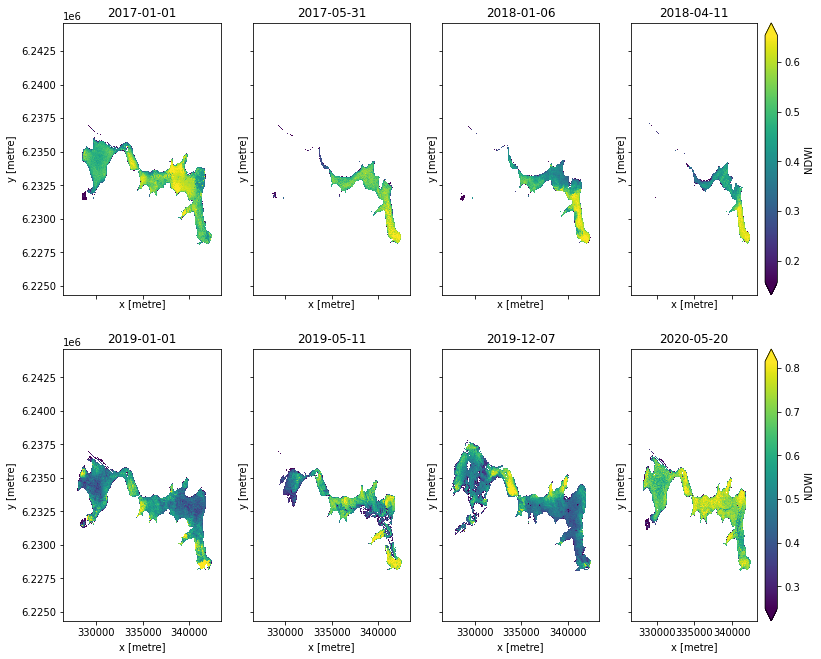

In [30]:
#plot
time_stamp = [0, 12, 30, 41, 70, 83, 104, 119]

# Plot water extent
fig, ax = plt.subplots(2, 4, figsize=(13, 11), sharex=True, sharey=True)

# plot the water extent from WOfS
#ds_wofs.isel(time=timestep_1).water.plot.imshow(ax=ax[1], cmap="Blues", add_colorbar=False)

ds_waterarea.NDWI.isel(time=time_stamp[0]).plot.imshow(ax=ax[0,0],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[1]).plot.imshow(ax=ax[0,1],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[2]).plot.imshow(ax=ax[0,2],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[3]).plot.imshow(ax=ax[0,3],cmap="viridis",robust=True, add_colorbar=True)
ds_waterarea.NDWI.isel(time=time_stamp[4]).plot.imshow(ax=ax[1,0],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[5]).plot.imshow(ax=ax[1,1],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[6]).plot.imshow(ax=ax[1,2],cmap="viridis",robust=True, add_colorbar=False)
ds_waterarea.NDWI.isel(time=time_stamp[7]).plot.imshow(ax=ax[1,3],cmap="viridis",robust=True, add_colorbar=True)

#title
ax[0,0].set_title(ds_waterarea.isel(time=time_stamp[0]).time.dt.strftime('%Y-%m-%d').data)#'2017-01')
ax[0,1].set_title(ds_waterarea.isel(time=time_stamp[1]).time.dt.strftime('%Y-%m-%d').data)#'2017-07')
ax[0,2].set_title(ds_waterarea.isel(time=time_stamp[2]).time.dt.strftime('%Y-%m-%d').data)#'2018-01')
ax[0,3].set_title(ds_waterarea.isel(time=time_stamp[3]).time.dt.strftime('%Y-%m-%d').data)#'2018-06') #this is actually the fifth month
ax[1,0].set_title(ds_waterarea.isel(time=time_stamp[4]).time.dt.strftime('%Y-%m-%d').data)#'2019-01')
ax[1,1].set_title(ds_waterarea.isel(time=time_stamp[5]).time.dt.strftime('%Y-%m-%d').data)#'2019-06')
ax[1,2].set_title(ds_waterarea.isel(time=time_stamp[6]).time.dt.strftime('%Y-%m-%d').data)#'2020-01')
ax[1,3].set_title(ds_waterarea.isel(time=time_stamp[7]).time.dt.strftime('%Y-%m-%d').data)#'2020-06')

# set labels
#plt.setp(ax[-1, :], xlabel='x axis label')
#plt.setp(ax[:, 0], ylabel='y axis label')

plt.show()

## Export Geotiff

In [26]:
#export geotiff

#index
time_stamp = [0, 12, 30, 41, 70, 83, 104, 119]

for i in time_stamp:

    # We will use the date of the satellite image to name the GeoTIFF
    date = ds_waterarea.isel(time=i).time.dt.strftime('%Y-%m-%d').data

    # Convert current time step into a `xarray.DataArray`
    singletimestamp_da = ds_waterarea.isel(time=i).to_array()
    
    # Write GeoTIFF
    write_cog(geo_im = singletimestamp_da,
              fname = f'{date}.tif',
              overwrite=False).compute()
    print(f'Writing {date}')


Writing 2017-01-01
Writing 2017-05-31
Writing 2018-01-06
Writing 2018-04-11
Writing 2019-01-01
Writing 2019-05-11
Writing 2019-12-07
Writing 2020-05-20


In [ ]:
##Work in progress

In [22]:
Thee_Extent_2017_2020 = xr_vectorize(da=waterarea,
                                     crs=ds_sen2.crs,
                                     #transform=ds_sen2.transform,
                                     transform=ds_sen2.geobox.transform
                                     #transform=Affine(10.0, 0.0, 326460.0, 0.0, -10.0, 6244600.0)#,
                                     #mask=waterarea.values==0)
                                    )

Thee_Extent_2017_2020.head()

ValueError: height must be > 0

In [ ]:
#plot
Thee_Extent_2017_2020.plot(figsize=(6, 6)

In [ ]:
Thee_Extent_2017_2020 = xr_vectorize(da=water_bodies,
                   crs=ds.crs,
                   transform=ds.geobox.transform,
                   mask=water_bodies.values == 1.,
                   export_shp='Thee_Extent_2017_2020.shp')